In [2]:
import pandas as pd
from pylab import *
import cv2
from sklearn.decomposition import PCA, RandomizedPCA
import os
import util.feature_util as feat
import cvxpy as cvx

%matplotlib inline

## Load data and features

In [162]:
df = pd.read_csv("../../data/images/features/CrowdFlower/BVLC/fc8_features.pkl")

In [164]:
df.head()
print df.shape

(9434, 13)


In [165]:
CNNfeatures = array(df.iloc[:,1:])
print CNNfeatures.shape

(9434, 12)


In [146]:
img_paths = list(df.iloc[:,0])

In [147]:
img_paths = ["../../data/images/imgs/" + img_path.split("data/")[-1] for img_path in img_paths]

## Find querry img dim

(500, 375, 3)


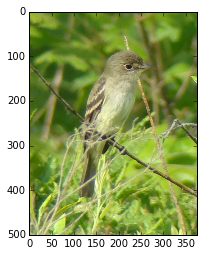

In [148]:
sample_id = 2000

img = cv2.imread(img_paths[sample_id])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)
print img.shape

## Load images and scale

In [149]:
width = 100
height = 100
DT = feat.DimTransformer(w = width, h = height)
imgs = DT.transform(img_paths)

In [150]:
img_arrays = zeros((len(imgs), width*height*3))
for i, img in enumerate(imgs):
    img_arrays[i,:] = reshape(img, (1,width*height*3))

In [151]:
img_arrays.shape

(6033, 30000)

## Compute Pairwise differences

In [152]:
def sample_diffs(sample, np_arr):
    diffs = np.sqrt((np_arr - sample)**2)
    return diffs

In [153]:
indx_list = [range(0,sample_id), range(sample_id+1, img_arrays.shape[0])]
indx = [item for sublist in indx_list for item in sublist]

X_diffs = sample_diffs(img_arrays[sample_id,:], img_arrays[indx,:])
y_diffs = sum(sample_diffs(CNNfeatures[sample_id,], CNNfeatures[indx,:]), axis=1)

In [154]:
print X_diffs.shape
print y_diffs.shape
print np.mean(y_diffs)

(6032, 30000)
(6032,)
8705.19191885


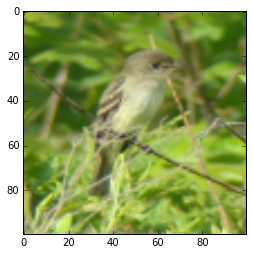

In [155]:
imshow(imgs[sample_id])

## Learn Optimal Weights

In [156]:
def optimize_weights(X_diffs, y_diffs):
    sc = np.linalg.norm(X_diffs)
    A = X_diffs/sc
    b = y_diffs/sc
    w = cvx.Variable(X_diffs.shape[1])
    #objective = cvx.Minimize(cvx.sum_entries(cvx.huber(A*w - b,1000)))
    objective = cvx.Minimize(cvx.norm(A*w - b,2))
    constraints = [0 <= w]

    prob = cvx.Problem(objective, constraints)
    prob.solve(solver=cvx.SCS)
    return prob.status, w.value

In [157]:
statusprob, weights = optimize_weights(X_diffs, y_diffs)

In [158]:
print min(array(weights)), median(array(weights)), max(array(weights))

[ -5.67605918e-06] 4.1713390596e-08 [ 0.30356142]


In [159]:
weights_thresh = np.array(weights).copy()
weights_thresh[weights_thresh < 1e-3] = 0
weights_thresh = 255.*weights_thresh/max(weights_thresh)
weights_reshape = reshape(weights_thresh, (height, width, 3))

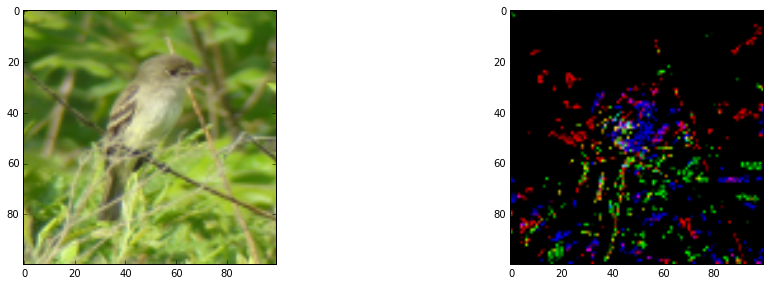

In [160]:
figure(figsize=(16, 10))
subplot(2,2,1)
imshow(imgs[sample_id])
subplot(2,2,2)
imshow(weights_reshape)